In [5]:
#!pip install fastai wwf bayesian-optimization -q --upgrade
#!pip install fastparquet
!pip install pyarrow

     --------------------------------------- 24.8/24.8 MB 34.4 MB/s eta 0:00:00


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os.path as osp 
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel #para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import set_config
set_config(display="diagram")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
#DATA_DIR = "/kaggle/input/fa-ii-2024-i-flujos-de-modelos-tradicionales/"
DATA_DIR = "../Taller_Practico/data/"
df = pd.read_parquet(osp.join(DATA_DIR, "df_train.parquet"))
df

,GENERO,ESTADO_CIVIL,FECHA_NACIMIENTO,CODIGO_SEDE,MULTI_CANCER,CESION,RIESGOS,CANCER_MAMA_FAMILIAR,CANCER_OTRO_SITIO,CANCER_OTRO_SITIO_FAMILIAR,...,radioterapias_cancer,quimioterapias__cancer,hormonoterapias__cancer,cuidado_palitiavo__cancer,inmunoterapias_cancer,Citas_oncologicas_cancer,psiquiatria_cancer,psicologia_cancer,nutricion_cancer,atencion_nutricion
ID,,,,,,,,,,,,,,,,,,,,,
2987,F,SO,1977-01-17,1051,None,0,2.0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,Sin servicios nutricion
3423,F,CA,1980-10-13,1028,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,5.0,1.0,1.0,0.0,Sin servicios nutricion
6981,F,SO,1951-10-28,1022,None,0,3.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Una servicio nutricion
6701,F,SO,1984-03-31,1026,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,Sin servicios nutricion
7361,F,UL,1974-03-28,1007,None,0,1.0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,Sin servicios nutricion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6344,F,UL,1979-08-20,1223,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,Sin servicios nutricion
4050,F,SO,1973-07-19,1007,None,0,2.0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sin servicios nutricion
1040,F,CA,1971-05-12,1008,None,0,1.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,3.0,Multiple servicio nutricion


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3955 entries, 2987 to 898
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   GENERO                      3955 non-null   object        
 1   ESTADO_CIVIL                3955 non-null   object        
 2   FECHA_NACIMIENTO            3955 non-null   datetime64[ns]
 3   CODIGO_SEDE                 3955 non-null   object        
 4   MULTI_CANCER                337 non-null    object        
 5   CESION                      3955 non-null   object        
 6   RIESGOS                     3955 non-null   float64       
 7   CANCER_MAMA_FAMILIAR        3955 non-null   object        
 8   CANCER_OTRO_SITIO           3955 non-null   object        
 9   CANCER_OTRO_SITIO_FAMILIAR  3955 non-null   object        
 10  CEREBRAL_FAMILIAR           3955 non-null   object        
 11  FECHA_DATOS_PESO_TALLA      3955 non-null   datetime64

In [42]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100

0.0    88.697851
1.0    11.302149
Name: Target, dtype: float64

In [43]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
) 

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [45]:
columnas_numerico=['MULTI_CANCER','RIESGOS','CESION','CANCER_MAMA_FAMILIAR','CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR']
X[columnas_numerico] = X[columnas_numerico].astype(float)

columnas_categ= ['GENERO','ESTADO_CIVIL',#'CODIGO_SEDE',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
X[columnas_categ] = X[columnas_categ].astype(str)

In [46]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

0.0    88.693841
1.0    11.306159
Name: Target, dtype: float64
0.0    88.720539
1.0    11.279461
Name: Target, dtype: float64


In [47]:
var_categoricas = ['GENERO','ESTADO_CIVIL',#'CODIGO_SEDE',
                 'CESION','CANCER_MAMA_FAMILIAR',
                'CANCER_OTRO_SITIO','CANCER_OTRO_SITIO_FAMILIAR','CEREBRAL_FAMILIAR'
                ,'atencion_nutricion'
                ]
var_numericas = X_train.select_dtypes('number').columns

# Data Processing

Ejemplo sobre como usar Pipelines: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1

In [48]:
from sklearn.base import BaseEstimator, TransformerMixin

In [49]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y) 
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

In [50]:
Imputer = SimpleImputer(strategy="median") # le estoy diciendo cual es la mediana para imputar
Scaler = StandardScaler() # se puede poner el minmaxscaler, robustscaler o otros # resto la media y divido la desviacion estandar
LDA = LinearDiscriminantAnalysis()

In [51]:
X_num = X[var_numericas].copy()

In [52]:
Imputer.fit(X_num)
X_num_proces = Imputer.transform(X_num)

In [53]:
X_num_proces

array([[  2.,  52., 149., ...,   0.,   0.,   0.],
       [  1.,  67., 163., ...,   1.,   1.,   0.],
       [  3.,  77., 152., ...,   0.,   0.,   1.],
       ...,
       [  1.,  45., 150., ...,   0.,   0.,   3.],
       [  0.,  60., 157., ...,   0.,   0.,   0.],
       [  4.,  62., 159., ...,   0.,   0.,   0.]])

In [54]:
Scaler.fit(X_num_proces)
X_num_proces = Scaler.transform(X_num_proces)

In [55]:
X_num_proces

array([[ 0.3812237 , -1.11122016, -1.09786153, ..., -0.16458836,
        -0.26479975, -0.37345961],
       [-0.42505424,  0.19691873,  1.00489516, ...,  1.39643554,
         0.99093527, -0.37345961],
       [ 1.18750164,  1.06901132, -0.64727082, ..., -0.16458836,
        -0.26479975,  0.65798785],
       ...,
       [-0.42505424, -1.72168497, -0.94766463, ..., -0.16458836,
        -0.26479975,  2.72088278],
       [-1.23133218, -0.41354609,  0.10371372, ..., -0.16458836,
        -0.26479975, -0.37345961],
       [ 1.99377959, -0.23912757,  0.40410753, ..., -0.16458836,
        -0.26479975, -0.37345961]])

In [56]:
LDA.fit(X_num_proces,y)

LinearDiscriminantAnalysis()

In [57]:
X_num_proces = LDA.transform(X_num_proces) ## tambien podria tenerse todos los antesriores y agregar el lda como columna adicional

In [58]:
X_num_proces

array([[ 0.39376537],
       [ 0.18280032],
       [ 0.69031987],
       ...,
       [-1.00729842],
       [ 0.76668694],
       [-0.59761324]])

In [59]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("LDA_feature",LDATransformer())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

In [60]:
preprocessor.fit(X,y)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('LDA_feature',
                                                  LDATransformer())]),
                                 Index(['RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA', 'mes_6',
       'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servicio',
       'IV_NIVEL', 'HOSPI_NO_QUIRURGICA', 'URGENCIAS', 'HOSPITALIZACION',...
       'cuidado_palitiavo__cancer', 'inmunoterapias_cancer',
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 ['GENERO', 'ESTADO_CIVIL', 'CESION',
                                  'CANCER_MAMA_FAMILIAR', 'CANCER_OTRO_SITIO',
                                  'CANCER_OTRO_SITIO_FAMILIAR',
                                  'CEREBRAL_FAMILIAR', 'atencion_nutricion'])])

In [61]:
X_a=preprocessor.transform(X)

In [62]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

# Bayesian optimization

In [63]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [64]:
data = collections.defaultdict(list)

def train_and_evaluate(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC='linear'

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    
    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls()),
               ("LDA_feature",LDATransformer()) 
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
    ])
           
    #Model SVM
    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel_SVC, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [] 
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate(**kwargs)
    return result


In [26]:
pbounds = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 10),
    SVC_gamma=(0,5),
   
)

optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds,
    random_state=963,
    verbose=2,
)


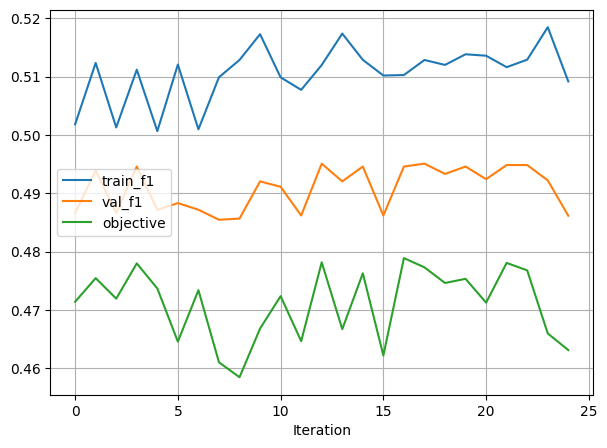

In [27]:
logger = JSONLogger(path="./logs.json")
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=20,
)

In [28]:
optimizer.max["params"]

{'SVC_C': 8.420183964104496,
 'SVC_gamma': 0.6483001959471806,
 'imputer_strategy': 0.43192982498708193,
 'knn_imputer': 0.36238852034982694,
 'knn_imputer_k': 8.174278596906545,
 'scaler_choice': 1.0}

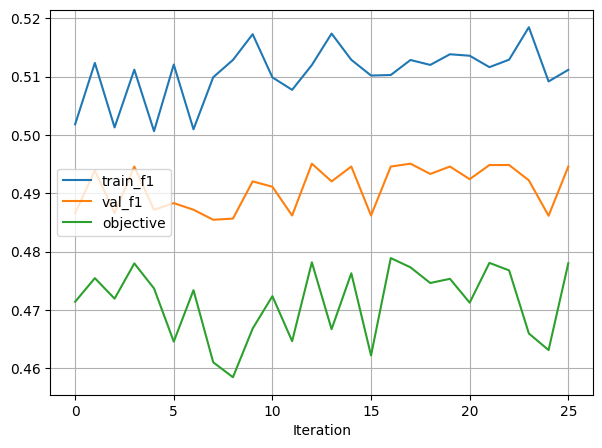

In [30]:
best_model, best_result = train_and_evaluate(**optimizer.max["params"])

In [31]:
test_preds = best_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, test_preds)

0.818743096660908

In [32]:
best_model.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler()),
                                                                                   ('LDA_feature',
                                                                                    LDATransformer())]),
                                                                   Index(['RIESGOS', 'PESO', 'TALLA', 'TSISTOLICA', 'TDIASTOLICA', 'mes_6',
       'mes_5', 'mes_4', 'mes_3', 'mes_2', 'mes_1', 'valor_servic...
       'Citas_oncologicas_cancer', 'psiquiatria_cancer', 'psicologia_cancer',
       'nutricion_cancer'],
      dtype='object')),
                                                                  ('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['GENERO',
                                                                    'ESTADO_CIVIL',
                                                                    'CESION',
                                                                    'CANCER_MAMA_FAMILIAR',
                                                                    'CANCER_OTRO_SITIO',
                                                                    'CANCER_OTRO_SITIO_FAMILIAR',
                                                                    'CEREBRAL_FAMILIAR',
                                                                    'atencion_nutricion'])]))])),
                ('model',
                 SVC(C=8.420183964104496, gamma=0.6483001959471806,
                     kernel='linear', probability=True))])

In [34]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [35]:
test_preds = best_model.predict_proba(X_test)[:, 1]
train_preds = best_model.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.1021021021021021

In [36]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")

Train f1: 0.5065963060686016
Test f1: 0.5538461538461538


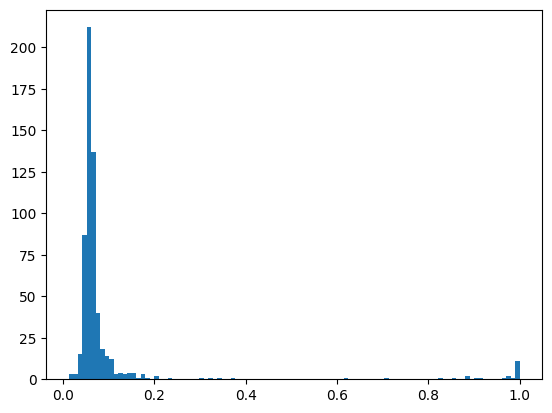

In [37]:
plt.hist(test_preds, bins=100)
plt.show()

# Submission

In [38]:
test_df = pd.read_parquet(osp.join(DATA_DIR, "df_test.parquet"))
submission_pred = best_model.predict_proba(test_df)[:, 1]
submission_pred_bool = submission_pred>best_th
submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred_int))
submission.to_csv("submission_SVC.csv", index=False)